In [1]:
from SimPEG import Mesh, Utils, EM, Maps
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from SimPEG import Mesh
import pandas as pd

In [2]:
mesh_3d, models = Mesh.TensorMesh.read_vtk("./time-lapse-synthetic.vtr")

AttributeError: type object 'TensorMesh' has no attribute 'read_vtk'

In [41]:
xmin, xmax = 0, 2800
# generate survey
x_inds = np.argwhere(np.logical_and(mesh_3d.vectorCCx > xmin, mesh_3d.vectorCCx < xmax))
x = mesh_3d.vectorCCx[x_inds][::2]
y = np.zeros_like(x)
src_height = 40.
z = np.ones_like(x) * 0.
src_locations_312 = np.c_[x, y, z + src_height]
rx_locations_312 = np.c_[x+13.25, y, z+2.+ src_height]
n_sounding_312 = src_locations_312.shape[0]
topo_312 = np.c_[x, y, z*0.]

In [42]:
x = mesh_3d.vectorCCx[x_inds][1::2]
y = np.zeros_like(x)  + 50.
src_height = 40.
z = np.ones_like(x) * 0.
src_locations_304 = np.c_[x, y, z + src_height]
rx_locations_304 = np.c_[x+13.25, y, z+2.+ src_height]
n_sounding_304 = src_locations_304.shape[0]
topo_304 = np.c_[x, y, z*0.]

In [43]:
active_inds = mesh_3d.gridCC[:,2] > 0.

In [44]:
mesh_2d = Mesh.TensorMesh([mesh_3d.hx, mesh_3d.hy], x0=mesh_3d.x0[:2])

In [45]:
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_312 = np.loadtxt("../aem-waveform/waveform_hm_312.txt")
waveform_lm_312 = np.loadtxt("../aem-waveform/waveform_lm_312.txt")
time_input_currents_hm_312 = waveform_hm_312[:,0] 
input_currents_hm_312 = waveform_hm_312[:,1]
time_input_currents_lm_312 = waveform_lm_312[:,0] 
input_currents_lm_312 = waveform_lm_312[:,1]

time_gates = np.loadtxt("../aem-waveform/time_gates")
GateTimeShift=-2.09E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_312 = waveform_lm_312[:,0].max()
times_lm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312

GateTimeShift=-1.5E-06
MeaTimeDelay=3.500E-04
NoGates=37
t0_hm_312 = waveform_hm_312[:,0].max()
times_hm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

In [46]:
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_304 = np.loadtxt("../aem-waveform/waveform_hm_304.txt")
waveform_lm_304 = np.loadtxt("../aem-waveform/waveform_lm_304.txt")
time_input_currents_hm_304 = waveform_hm_304[:,0] 
input_currents_hm_304 = waveform_hm_304[:,1]
time_input_currents_lm_304 = waveform_lm_304[:,0] 
input_currents_lm_304 = waveform_lm_304[:,1]

time_gates = np.loadtxt("../aem-waveform/time_gates")
GateTimeShift=-2.09E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_304 = waveform_lm_304[:,0].max()
times_lm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_304

GateTimeShift=-1.5E-06
MeaTimeDelay=3.500E-04
NoGates=37
t0_hm_304 = waveform_hm_304[:,0].max()
times_hm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_304    

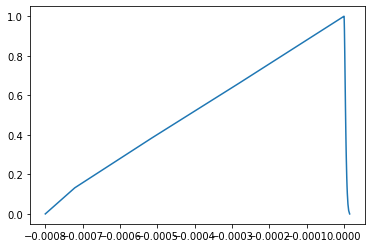

In [47]:
plt.plot(time_input_currents_lm_312, input_currents_lm_312)

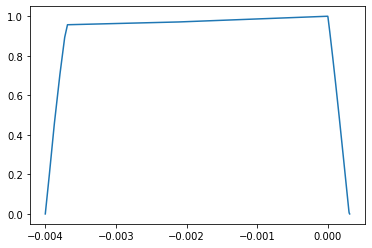

In [48]:
plt.plot(time_input_currents_hm_312, input_currents_hm_312)

In [49]:
from SimPEG import (
    Regularization, Directives, Inversion, 
    InvProblem, Optimization, DataMisfit, Utils, Maps
)
from simpegEM1D import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, 
    get_vertical_discretization_time, EM1DSurveyTD,
    get_2d_mesh, LateralConstraint, 
)
from pymatsolver import PardisoSolver

In [50]:
hz = np.array([ 2.999232 ,  3.1991808,  3.3991296,  3.6990528,  3.8990016,
        4.1989248,  4.498848 ,  4.7987712,  5.0986944,  5.498592 ,
        5.8984896,  6.2983872,  6.6982848,  7.1981568,  7.6980288,
        8.1979008,  8.7977472,  9.3975936, 10.0974144, 10.7972352,
       11.497056 , 12.2968512, 13.1966208, 14.0963904, 14.99616  ,
       16.0958784, 17.1955968, 18.3952896, 19.6949568, 21.0945984,
       22.49424  , 24.0938304, 25.7933952, 27.49296  , 29.492448 ,
       31.491936 , 33.6913728, 35.990784 , 38.490144 ])

In [52]:
data_312 = np.load("../aem-waveform/data_1.npy")
data_304 = np.load("../aem-waveform/data_2.npy")

In [53]:
DATA_312 = data_312.reshape(
    (times_hm_312.size+times_lm_312.size, n_sounding_312), 
    order='F'
)

In [54]:
DATA_304 = data_304.reshape(
    (times_hm_304.size+times_lm_304.size, n_sounding_304), 
    order='F'
)

In [55]:
DATA = np.hstack((DATA_312, DATA_304)).T

In [56]:
n_sounding = n_sounding_312 + n_sounding_304
mesh = get_2d_mesh(n_sounding, hz)
rx_locations = np.vstack((rx_locations_312, rx_locations_304))
src_locations = np.vstack((src_locations_312, src_locations_304))
topo = np.vstack((topo_312, topo_304))

time = []
time_dual_moment = []
input_currents = []
time_input_currents = []
input_currents_dual_moment = []
time_input_currents_dual_moment = []

for i_sounding in range(n_sounding_312):
    time.append(times_hm_312)
    time_dual_moment.append(times_lm_312)
    time_input_currents.append(time_input_currents_hm_312)
    input_currents.append(input_currents_hm_312)
    time_input_currents_dual_moment.append(time_input_currents_lm_312)
    input_currents_dual_moment.append(input_currents_lm_312)  

for i_sounding in range(n_sounding_304):
    time.append(times_hm_304)
    time_dual_moment.append(times_lm_304)
    time_input_currents.append(time_input_currents_hm_304)
    input_currents.append(input_currents_hm_304)
    time_input_currents_dual_moment.append(time_input_currents_lm_304)
    input_currents_dual_moment.append(input_currents_lm_304)      

In [57]:
mapping = Maps.ExpMap(mesh)

survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    topo = topo,
    time = time,
    time_dual_moment = time_dual_moment,
    src_type = np.array(["VMD"], dtype=str).repeat(n_sounding),
    rx_type = np.array(["dBzdt"], dtype=str).repeat(n_sounding),    
    offset = np.array([13.25], dtype=float).repeat(n_sounding).reshape([-1,1]),    
    wave_type = np.array(["general"], dtype=str).repeat(n_sounding),    
    field_type = np.array(["secondary"], dtype=str).repeat(n_sounding),    
    input_currents=input_currents,
    time_input_currents=time_input_currents,
    base_frequency = np.array([30.]).repeat(n_sounding),
    input_currents_dual_moment=input_currents_dual_moment,
    time_input_currents_dual_moment=time_input_currents_dual_moment,
    base_frequency_dual_moment = np.array([210.]).repeat(n_sounding),
    moment_type=np.array(["dual"], dtype=str).repeat(n_sounding)
)

prob = GlobalEM1DProblemTD(
    [], sigmaMap=mapping, hz=hz, parallel=True, n_cpu=10,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Set parameters
>> Use multiprocessing for parallelization
>> n_cpu: 10


In [58]:
std = 0.05
dobs = DATA.flatten()
uncert = abs(dobs)*std
survey.dobs = dobs

In [60]:
mesh = get_2d_mesh(n_sounding, hz)
m0 = np.ones(mesh.nC) * np.log(1./10.)
regmap = Maps.IdentityMap(mesh)
# mapping is required ... for IRLS
reg = LateralConstraint(
    mesh, mapping=regmap,
    alpha_s = 1e-5,
    alpha_x = 1.,
    alpha_y = 1.,    
)
reg.get_grad_horizontal(topo[:,:2], hz, dim=3, use_cell_weights=True, minimum_distance=1000.)
np.random.seed(1)
dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.W = 1./uncert
opt = Optimization.InexactGaussNewton(maxIter=20, maxIterCG=20)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit(chifact=1.)
save_model = Directives.SaveOutputDictEveryIteration()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.39e+02  2.35e+06  0.00e+00  2.35e+06    1.94e+05      0              
   1  1.19e+02  2.50e+05  1.85e-01  2.50e+05    2.76e+04      0              
   2  5.97e+01  4.50e+04  7.18e+01  4.92e+04    3.86e+03      0   Skip BFGS  
   3  2.98e+01  1.97e+04  2.52e+02  2.72e+04    1.51e+03      0   Skip BFGS  
   4  1.49e+01  1.71e+04  2.54e+02  2.09e+04    1.43e+03      1              
   5  7.46e

In [61]:
line = np.r_[np.ones(n_sounding_312), np.ones(n_sounding_304)*2]

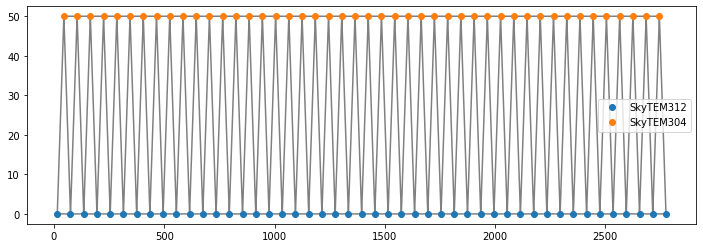

In [62]:
fig = plt.figure(figsize=(12, 4))
tri = reg.get_grad_horizontal(topo[:,:2], hz)

plt.plot(topo_312[:,0], topo_312[:,1], 'o')
plt.plot(topo_304[:,0], topo_304[:,1], 'o')
plt.legend(("SkyTEM312", "SkyTEM304"))
plt.triplot(topo[:,0], topo[:,1], tri.simplices, color='grey')
plt.show()

In [65]:
from scipy.interpolate import NearestNDInterpolator
f_int = NearestNDInterpolator(mesh_3d.gridCC, models['rho_3'])
rho_true_3 = f_int(IO.xyz.reshape((hz.size*n_sounding, 3), order='F'))
f_int = NearestNDInterpolator(mesh_3d.gridCC, models['rho_1'])
rho_true_1 = f_int(IO.xyz.reshape((hz.size*n_sounding, 3), order='F'))

In [66]:
from matplotlib.colors import LogNorm

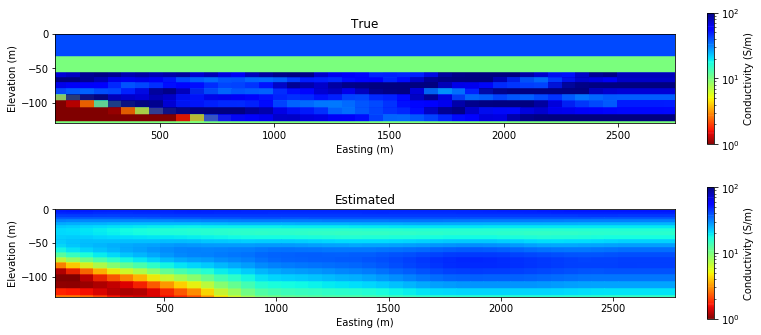

In [70]:
from simpegEM1D import ModelIO
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
nskip = 1
IO = ModelIO(
    hz=hz,
    topography=topo[::nskip,:], 
    physical_property=1./np.exp(Utils.mkvc(mopt.reshape((hz.size, n_sounding), order='F')[:,::nskip])),
    line=line[::nskip]
)

IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r', aspect=20, clim=(1, 100), dx=250, i_line=0, ax=axs[1])

nskip = 1
IO = ModelIO(
    hz=hz,
    topography=topo[::nskip,:], 
    physical_property=rho_true_1,
    line=line[::nskip]
)
IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r', aspect=20, clim=(1, 100), dx=250, i_line=1, ax=axs[0])

titles = ['True', 'Estimated']
for ii, ax in enumerate(axs):
    ax.set_title(titles[ii])
    ax.set_ylim(-130, 0)
    ax.set_aspect(3)
    

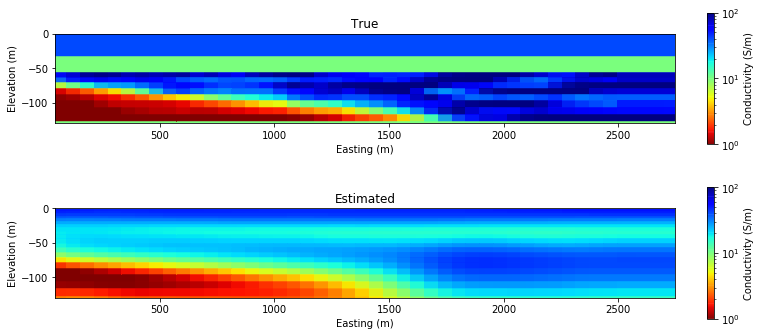

In [71]:
from simpegEM1D import ModelIO
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
nskip = 1
IO = ModelIO(
    hz=hz,
    topography=topo[::nskip,:], 
    physical_property=1./np.exp(Utils.mkvc(mopt.reshape((hz.size, n_sounding), order='F')[:,::nskip])),
    line=line[::nskip]
)

IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r', aspect=20, clim=(1, 100), dx=250, i_line=1, ax=axs[1])

nskip = 1
IO = ModelIO(
    hz=hz,
    topography=topo[::nskip,:], 
    physical_property=rho_true_3,
    line=line[::nskip]
)
IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet_r', aspect=20, clim=(1, 100), dx=250, i_line=1, ax=axs[0])
titles = ['True', 'Estimated']
for ii, ax in enumerate(axs):
    ax.set_title(titles[ii])
    ax.set_ylim(-130, 0)
    ax.set_aspect(3)
